borrowed from https://huggingface.co/learn/cookbook/en/fine_tuning_vit_custom_dataset

In [2]:
from datasets import Dataset, DatasetDict
import torch
import sys
sys.path.append("/Users/michaelcheng/Desktop/AI_projects/kaggle_cancer_classification/src/")
import data.dataset as ds
from pathlib import Path
import matplotlib.pyplot as plt
from transformers import ViTImageProcessor, ViTForImageClassification
from torchvision.transforms import CenterCrop, Compose, Normalize, RandomHorizontalFlip, RandomResizedCrop, ToTensor, Resize
from torch.utils.data import DataLoader

from peft import PeftModel, LoraConfig, get_peft_model

/opt/miniconda3/envs/pytorch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# config
data_root = "/Users/michaelcheng/Desktop/AI_projects/kaggle_cancer_classification/IDC_regular_ps50_idx5"
batch_size = 32
num_workers = 0
val_ratio = 0.15
test_ratio = 0.15
image_size = 128
random_seed = 42

In [4]:
subject_ids = [p.name for p in Path(data_root).glob("*/")]

In [5]:

dataset = ds.IDCDataset(data_root=data_root, subject_ids=subject_ids, transform=None)

In [6]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=50x50>, 0)

In [7]:
# create a generator for the DataLoader to convert to Hugging Face Dataset
def gen():
    for (image, label) in dataset:
        yield {
            "features": image,
            "label": label
        }

In [8]:
# train val test split
hf_dataset = Dataset.from_generator(gen)
hf_dataset = hf_dataset.train_test_split(test_size=test_ratio, seed=random_seed)
train_val_split = hf_dataset["train"].train_test_split(test_size=val_ratio, seed=random_seed)
hf_dataset = DatasetDict({
    "train": train_val_split["train"],
    "val": train_val_split["test"],
    "test": hf_dataset["test"]
})

train_ds = hf_dataset["train"]
val_ds = hf_dataset["val"]
test_ds = hf_dataset["test"]


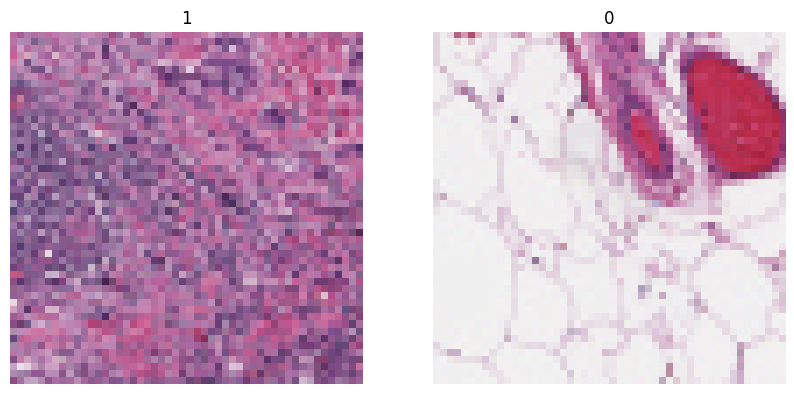

In [9]:

# Initialize a set to keep track of shown labels
shown_labels = set()

# Initialize the figure for plotting
plt.figure(figsize=(10, 10))

# Loop through the dataset and plot the first image of each label
for i, sample in enumerate(train_ds):
    label = sample['label']
    if label not in shown_labels:
        plt.subplot(1, 2, len(shown_labels) + 1)
        plt.imshow(sample['features'])
        plt.title(label)
        plt.axis('off')
        shown_labels.add(label)
        if len(shown_labels) == 2:
            break

plt.show()

In [10]:
# label mapping
id2label = {0: 'No IDC', 1: 'IDC'}
label2id = {v: k for k, v in id2label.items()}


# Image Processing

In [11]:

model_name = "google/vit-large-patch16-224"
processor = ViTImageProcessor.from_pretrained(model_name)

In [12]:

image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

normalize = Normalize(mean=image_mean, std=image_std)

train_transforms = Compose([        
    RandomResizedCrop(size),
    RandomHorizontalFlip(),
    ToTensor(),
    normalize,
])
val_transforms = Compose([
    Resize(size),
    CenterCrop(size),
    ToTensor(),
    normalize,
])
test_transforms = Compose([
    Resize(size),
    CenterCrop(size),
    ToTensor(),
    normalize,
])

In [13]:
def apply_train_transforms(examples):
    examples['pixel_values'] = [train_transforms(image.convert("RGB")) for image in examples['features']]
    return examples

def apply_val_transforms(examples):
    examples['pixel_values'] = [val_transforms(image.convert("RGB")) for image in examples['features']]
    return examples

def apply_test_transforms(examples):
    examples['pixel_values'] = [val_transforms(image.convert("RGB")) for image in examples['features']]
    return examples

In [14]:
train_ds.set_transform(apply_train_transforms)
val_ds.set_transform(apply_val_transforms)
test_ds.set_transform(apply_test_transforms)

In [15]:
train_ds[0]


{'features': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=50x50>,
 'label': 1,
 'pixel_values': tensor([[[ 0.4431,  0.4431,  0.4431,  ...,  0.3569,  0.3569,  0.3569],
          [ 0.4431,  0.4431,  0.4431,  ...,  0.3569,  0.3569,  0.3569],
          [ 0.4431,  0.4431,  0.4431,  ...,  0.3569,  0.3569,  0.3569],
          ...,
          [ 0.4039,  0.4039,  0.4039,  ...,  0.2235,  0.2235,  0.2235],
          [ 0.4039,  0.4039,  0.4039,  ...,  0.2235,  0.2235,  0.2235],
          [ 0.4039,  0.4039,  0.4039,  ...,  0.2235,  0.2235,  0.2235]],
 
         [[-0.1294, -0.1294, -0.1294,  ..., -0.1059, -0.1059, -0.1059],
          [-0.1294, -0.1294, -0.1294,  ..., -0.1059, -0.1059, -0.1059],
          [-0.1294, -0.1294, -0.1294,  ..., -0.1059, -0.1059, -0.1059],
          ...,
          [-0.2078, -0.2078, -0.2078,  ..., -0.2392, -0.2392, -0.2392],
          [-0.2078, -0.2078, -0.2078,  ..., -0.2392, -0.2392, -0.2392],
          [-0.2078, -0.2078, -0.2078,  ..., -0.2392, -0.2392, -0.2392]],

In [16]:
# Data Loading
# collate function as simple stacking of data items into a batch
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dl = DataLoader(train_ds, collate_fn=collate_fn, batch_size=batch_size, num_workers = num_workers)

In [17]:
batch = next(iter(train_dl))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([32, 3, 224, 224])
labels torch.Size([32])


# Fine Tuning

In [18]:
# call model
base_model = ViTForImageClassification.from_pretrained(model_name, id2label=id2label, label2id=label2id, ignore_mismatched_sizes=True)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-large-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([2, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
def print_model_size(path):
    size = 0
    for f in os.scandir(path):
        size += os.path.getsize(f)

    print(f"Model Size: {(size / 1e6):.2} MB")


def print_trainable_parameters(model, label):
    params, trainable = 0, 0
    
    for _, p in model.named_parameters():
        params += p.numel()
        trainable += p.numel() if p.requires_grad else 0

    print(f"{label} trainable parameters: {trainable:,}/{params:,} ({100 * trainable / params:.2f}%)")

In [20]:
print_trainable_parameters(base_model, 'Base Model')

Base Model trainable parameters: 303,303,682/303,303,682 (100.00%)


In [21]:
# build lora model
def build_lora_model(label2id, id2label):
    base_model = ViTForImageClassification.from_pretrained(model_name, id2label=id2label, label2id=label2id, ignore_mismatched_sizes=True)
    print_trainable_parameters(base_model, label="Base Model")

    config = LoraConfig(
        r=16,
        lora_alpha=16,
        target_modules=["query", "value"],
        lora_dropout=0.1,
        bias="none",
        modules_to_save=["classifier"],
    )

    lora_model = get_peft_model(base_model, config)
    print_trainable_parameters(lora_model, label="LoRA")

    return lora_model

In [22]:
# Training Arguments
from transformers import TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import accuracy_score

# Define compute_metrics function for evaluation
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(labels, predictions)
    return {"accuracy": accuracy}

train_args = TrainingArguments(
    output_dir = "output-models",
    save_total_limit=2,
    report_to="none",
    # report_to="wandb", # only use if you have Weights and Biases account
    save_strategy="epoch",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=4,
    num_train_epochs=1,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",  # Use accuracy instead of eval_loss
    logging_dir='logs',
    remove_unused_columns=False,
)

In [23]:
# subset train_ds
train_ds = train_ds.select(range(10000))
val_ds = val_ds.select(range(100))
test_ds = test_ds.select(range(100))
trainer = Trainer(
    build_lora_model(label2id, id2label),
    train_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    processing_class=processor,
)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-large-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([2, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Base Model trainable parameters: 303,303,682/303,303,682 (100.00%)
LoRA trainable parameters: 1,574,914/304,878,596 (0.52%)


In [24]:
results = trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy
1,0.397300,0.344546,0.830000


In [25]:
evaluation_results = trainer.evaluate(test_ds)
print(f"Evaluation accuracy: {evaluation_results['eval_accuracy']}")



Evaluation accuracy: 0.82


In [26]:
outputs = trainer.predict(test_ds)
print(outputs.metrics)

{'test_loss': 0.4154174327850342, 'test_accuracy': 0.82, 'test_runtime': 5.1948, 'test_samples_per_second': 19.25, 'test_steps_per_second': 4.813}


In [27]:
# save the fine-tuned model to disk.
import os
trainer.save_model("./lora-model")
print_model_size("./lora-model")

Model Size: 1.2e+03 MB


In [35]:
outputs.predictions.argmax(axis=1)

array([0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])